This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week3` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 3.1. Supervised Learning: Nearest Neighbor

In this problem, we will use $k$-Nearest Neighbors to see if we can use machine learning techniques to predict departure delays at the O'Hare airport (ORD). For simplicity, we will use only six attributes: `Month`, `DayofMonth`, `DayOfWeek`, `CRSDepTime`, `CRSArrTime`, and `Distance`.

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_in, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

sns.set(style="white")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We use the 2001 on-time airline performance data set. We import the following columns:

- Column 1: Month, 1-12
- Column 2: DayofMonth, 1-31
- Column 3: DayOfWeek, 1 (Monday) - 7 (Sunday)
- Column 5: CRSDepTime, scheduled departure time (local, hhmm)
- Column 7: CRSArrTime, scheduled arrival time (local, hhmm)
- Column 15: DepDelay, departure delay, in minutes
- Column 16: Origin, origin IATA airport code
- Column 18: Distance, in miles

In [2]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(1, 2, 3, 5, 7, 15, 16, 18)
    )

We use only the flights that departed from ORD. We define a flight to be delayed if its departure delay is 15 minutes or more, the same definition used by the FAA (source: [Wikipedia](https://en.wikipedia.org/wiki/Flight_cancellation_and_delay)).

In [3]:
local = df[df['Origin'] == 'ORD']
local = local.drop('Origin', axis=1) # we don't need the Origin column anymore.
local['Delayed'] = (local['DepDelay'] >= 15).astype(np.int) # 1 if a flight was delayed, 0 if not.
local = local.drop('DepDelay', axis=1).dropna() # we don't need the DepDelay column.

Let's print the first few columns and see what we'll be working with.

```python
>>> print(local.head(5))
```

```
      Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Delayed
6367      1           1          1         951        1235       599        0
6368      1           2          2         951        1235       599        0
6369      1           3          3         951        1235       599        0
6370      1           4          4         951        1235       599        1
6371      1           5          5         951        1235       599        0
```

In [4]:
print(local.head(5))

      Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Delayed
6367      1           1          1         951        1235       599        0
6368      1           2          2         951        1235       599        0
6369      1           3          3         951        1235       599        0
6370      1           4          4         951        1235       599        1
6371      1           5          5         951        1235       599        0


## Split

Write a function named `split()` that takes a DataFrame as its first argument and returns a 4-tuple of DataFrames. The second argument `test_column` specifies which column should be used as a label (`Delayed` in our case). All remaining columns except `test_column` should be used for training. In other words, the returned DataFrames `y_train` and `y_test` both have only one column, `test_column`, and `X_train` and `X_test` contain all columns in `df` minus `test_column`.

Don't forget that we have to pass an instance of `check_random_state()` to the `train_test_split()` function for reproducibility.

In [5]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    ##################
    # YOUR CODE HERE
    train_column = df.columns.drop(test_column) # select the train columns
    X = df[train_column]
    y = df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=test_size, random_state=random_state)
    ##################
    
    return X_train, X_test, y_train, y_test

Now we will split `local` into a training set (used for training our model), a validation set (used for determining hyperparameters), and a test set (used for evaluating our model's performance). We can use the `split` function twice with different `test_size` to split `local` into training:validation:test = 60:20:20.

In [6]:
X_train_valid, X_test, y_train_valid, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

In the following code cell, we test if the returned DataFrames have the correct columns and lengths.

In [7]:
assert_equal(isinstance(X_train_valid, pd.DataFrame), True)
assert_equal(isinstance(X_test, pd.DataFrame), True)
assert_equal(isinstance(y_train_valid, pd.DataFrame), True)
assert_equal(isinstance(y_test, pd.DataFrame), True)

assert_equal(len(X_train_valid) - np.round(len(local) * 0.8) <= 1, True)
assert_equal(len(X_test) - np.round(len(local) * 0.2) <= 1, True)
assert_equal(len(y_train_valid) - np.round(len(local) * 0.8) <= 1, True)
assert_equal(len(y_test) - np.round(len(local) * 0.2) <= 1, True)

assert_index_equal(X_train_valid.columns, local.columns.drop('Delayed'))
assert_index_equal(X_test.columns, local.columns.drop('Delayed'))
assert_equal(y_train_valid.columns, pd.Index(['Delayed']))
assert_equal(y_test.columns, pd.Index(['Delayed']))

We split `X_train_valid` and `y_train_valid` (80% of `local`) by using `test_size = 0.25`, which makes `X_train` and `y_train` 60% of `local`, and `X_valid` and `y_valid` 20 % of `local`.

In [8]:
X_train, X_valid, y_train, y_valid = split(
    df=X_train_valid.join(y_train_valid),
        test_column=['Delayed'],
    test_size=0.25,
    random_state=check_random_state(0)
    )

We've already checked the types of returned values and the columns, so now we only check the lengths and indices.

In [9]:
assert_equal(len(X_train) - np.round(len(local) * 0.6) <= 1, True)
assert_equal(len(X_valid) - np.round(len(local) * 0.2) <= 1, True)
assert_equal(len(y_train) - np.round(len(local) * 0.6) <= 1, True)
assert_equal(len(X_valid) - np.round(len(local) * 0.2) <= 1, True)

assert_index_equal(X_train.index[:5], pd.Int64Index([5903153, 1200840, 4524718, 2419368, 4017270]))
assert_index_equal(X_valid.index[:5], pd.Int64Index([722372, 3342898, 4673529,  896758, 1744337]))
assert_index_equal(y_train.index, X_train.index)
assert_index_equal(y_valid.index, X_valid.index)

## Normalize

Note that the six columns we want to use for training have different scales.

```python
>>> print(local.min())
```

```
Month           1
DayofMonth      1
DayOfWeek       1
CRSDepTime    530
CRSArrTime      1
Distance       67
Delayed         0
dtype: int64
```

In [10]:
print(local.min())

Month           1
DayofMonth      1
DayOfWeek       1
CRSDepTime    530
CRSArrTime      1
Distance       67
Delayed         0
dtype: int64


```python
>>> print(local.max())
```

```
Month           12
DayofMonth      31
DayOfWeek        7
CRSDepTime    2245
CRSArrTime    2359
Distance      4243
Delayed          1
dtype: int64
```

In [11]:
print(local.max())

Month           12
DayofMonth      31
DayOfWeek        7
CRSDepTime    2245
CRSArrTime    2359
Distance      4243
Delayed          1
dtype: int64


Before we apply the machine learning technique, we should standardize the features. One way to do this is to rescale the range of features to [0, 1]:

$$x' = \frac{x - \text{min}(x)}{\text{max}(x)-\text{min}(x)}$$

where $x$ is an original value, $x'$ is the normalized value.

In [12]:
def normalize(df):
    '''
    Takes a dataframe and normlizes features to be in range [0, 1].
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    ##################
    # YOUR CODE HERE
    result = df.copy()
    for i in result.columns:
        max_value = max(result[i])
        min_value = min(result[i])
        result[i] = (result[i] - min_value) / (max_value - min_value)
    ##################
    return result

Let's check our function by printing out the minimum and maximum values.

```python
>>> X_train_normal, X_valid_normal = map(normalize, [X_train, X_valid])
>>> print(X_train_normal.min())
```

```
Month         0
DayofMonth    0
DayOfWeek     0
CRSDepTime    0
CRSArrTime    0
Distance      0
dtype: float64
```

```python
>>> print(X_train_normal.max())
```

```
Month         1
DayofMonth    1
DayOfWeek     1
CRSDepTime    1
CRSArrTime    1
Distance      1
dtype: float64
```

In [13]:
X_train_normal, X_valid_normal = map(normalize, [X_train, X_valid])
print(X_train_normal.min())

Month         0
DayofMonth    0
DayOfWeek     0
CRSDepTime    0
CRSArrTime    0
Distance      0
dtype: float64


In [14]:
print(X_train_normal.max())

Month         1
DayofMonth    1
DayOfWeek     1
CRSDepTime    1
CRSArrTime    1
Distance      1
dtype: float64


Unit tests.

In [15]:
df0 = pd.DataFrame({
    'a': [0, 1, 2, 3, 4],
    'b': [-50, -20, 10, 45, 50],
    'c': [-200, 450, 100, 500, -500]
    })

test1 = normalize(df0)
answer1 = pd.DataFrame({
    'a': [0., 0.25, 0.5, 0.75, 1.],
    'b': [0., 0.3, 0.6, 0.95, 1.],
    'c': [0.3, 0.95, 0.6, 1., 0.]
    })
assert_frame_equal(test1, answer1)

## Train a k-Nearest Neighbors model

Now that we have standardized the training and validation sets, we are finally ready to apply the $k$-Nearest Neighbors algorithm. We will break it down into small steps.

First, write a function named `train_knn()` that fits a $k$-Nearest Neighbors on the training data and returns the trained model (an `sklearn.neighbors.KNeighborsClassifier` object).

In [16]:
def train_knn(X, y, n_neighbors):
    '''
    Fits a $k$-Nearest Neighbors on the training data.
    Returns the trained model (an `sklearn.neighbors.KNeighborsClassifier` object).
    
    Parameters
    ----------
    X: A pandas.DataFrame. Training attributes.
    y: A pandas.DataFrame. Truth labels.
    n_neighbors: Number of neighbors to use in kNN.
    
    Returns
    -------
    An sklearn.neighbors.KNeighborsClassifier object.
    '''
    ##################
    # YOUR CODE HERE
    model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    y = np.array(y).reshape([len(y)])
    model.fit(X, y)
    ##################

    return model

In [17]:
test_X_train = pd.DataFrame({
    'a': np.random.rand(100),
    'b': np.random.rand(100)
    })
test_y_train = pd.DataFrame({
    'y': np.floor(np.random.rand(100) * 2)
    })

test2 = train_knn(test_X_train, test_y_train, 1)

assert_equal(isinstance(test2, neighbors.KNeighborsClassifier), True)
assert_equal(test2.n_neighbors, 1)
assert_array_almost_equal(test2._fit_X, test_X_train)
assert_array_equal(test2._y, test_y_train.values.ravel())

# test with different n_neighbors
test3 = train_knn(test_X_train, test_y_train, 5)
assert_equal(test3.n_neighbors, 5)
assert_array_almost_equal(test3._fit_X, test_X_train)
assert_array_equal(test3._y, test_y_train.values.ravel())

## Predict

Write a function named `predict_knn()` that fits an `sklearn.neighbors.KNeighborsClassifier` model on `X` and returns a **pandas.DataFrame** of predicted values. Note that sklearn's `predict()` function will return a Numpy array even if you pass in a DataFrame. You should convert this array to a DataFrame because we will compare the predictions with `y_test` which is a DataFrame. Alternatively, you may choose to convert all DataFrames to arrays and work with arrays. You just have to be consistent with data types, and we simply choose to prefer DataFrames here.

In [18]:
def predict_knn(model, X):
    '''
    Fits an `sklearn.neighbors.KNeighborsClassifier` model on `X` and
    returns a `numpy.ndarray` of predicted values.
    
    Parameters
    ----------
    model: An sklearn.neighbors.KNeighborsClassifier object.
    X: pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame. Has one column "Delayed".
    '''
    ##################
    # YOUR CODE HERE
    prediction = model.predict(X)
    prediction = pd.DataFrame(prediction, columns = ['Delayed'])
    ##################

    return prediction

In [19]:
test4_model = train_knn(X_train, y_train, 1)
test4 = predict_knn(test4_model, X_valid)[:10]
answer4 = pd.DataFrame({
    'Delayed': [1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
    })

assert_equal(isinstance(test4, pd.DataFrame), True)
assert_frame_equal(test4, answer4)

test5_model = train_knn(X_train, y_train, 3)
test5 = predict_knn(test5_model, X_valid)[:10]
answer5 = pd.DataFrame({
    'Delayed': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

    })
assert_frame_equal(test5, answer5)

test6_model = train_knn(X_train, y_train, 5)
test6 = predict_knn(test6_model, X_valid)[:10]
answer6 = pd.DataFrame({
    'Delayed': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    })
assert_frame_equal(test6, answer6)

## Use accuracy to find the best model

We are now going to use the validation set to search for the best value of $k$ from from $k=1$ to $k=50$. Thus, write a function named `compute_accuracy()` that trains 50 $k$-Nearest Neighbors model and returns a Numpy array of 50 accuracy scores for each model with different values of $k$.

In [20]:
def compute_accuracy(X_train, X_valid, y_train, y_valid, start=1, end=51):
    '''
    Find accuracy scores for kNN classifers
    with n_neighbors = start, start + 1, start + 2, ..., end - 1.
    Returns a Numpy array of length end - start.
    For example, if start=1 and end=4, then len(scores) = 3, and
    scores[0] cooresponds to the accuracy of kNN with k=1,
    scores[1] the accuracy of kNN with k=2, ..., and
    scores[2] the accuracy of KNN with k=3.
    
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    X_valid: A pandas.DataFrame
    y_train: A pandas.DataFrame
    y_valid: A pandas.DataFrame
    start: An int.
    end: An int.
    
    Returns
    -------
    A numpy.ndarray
    '''
    ##################
    # YOUR CODE HERE
    k_neigh = np.arange(start, end, 1)
    scores = np.zeros(len(k_neigh))
    for i in range(len(k_neigh)):
        k = k_neigh[i]
        model = train_knn(X_train, y_train, k)
        prediction = predict_knn(model, X_valid)
        scores[i] = np.sum((prediction.values==y_valid.values).astype(int))/len(prediction)
        
    ##################

    return scores

We will search the hyperparameter space ranging from $k=1$ to $k=50$ for the best accuracy score, but let's perform a short test first to see if the function is correct.

In [21]:
test6 = compute_accuracy(X_train, X_valid, y_train, y_valid, 2, 5)
assert_array_almost_equal(test6, [0.78034487, 0.74846536, 0.78298197])

Now do a full search from $k=1$ to $k=50$. This might take a while.

In [22]:
scores = compute_accuracy(X_train, X_valid, y_train, y_valid, 1, 51)
k_best = np.argmax(scores) + 1 # because we started counting from k=1
print('The best model: k = {}'.format(k_best))

The best model: k = 48


Now that we have decided on our model ($k=48$), we can now use **both** the training set and the validation set for training, and then use the test set to evaulate the performance.

```python
>>> print("The accuracy score on the test set is {:2.1f}%.".format(accuracy * 100))
```

```
The accuracy of k-Nearest Neighbors is 82.0%.
```

Don't forget to normalize the data sets.

In [23]:
X_train_valid_normal, X_test_normal = map(normalize, [X_train_valid, X_test])

final_model = train_knn(X_train_valid_normal, y_train_valid, n_neighbors=k_best)
y_pred = predict_knn(final_model, X_test_normal)

accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of k-Nearest Neighbors is {:2.1f}%.".format(accuracy * 100))

The accuracy of k-Nearest Neighbors is 82.0%.


An accuracy of 82% looks pretty good, but we have to be careful when dealing with an unbalanced data set such as ours.

```python
>>> print((y_train == 0).sum())
```

```
Delayed    163110
dtype: int64
```

```python
>>> print((y_train == 1).sum())
```

```
Delayed    41660
dtype: int64
```

Flights that were not delayed outnumber delayed flights by 4-to-1. What would happen if we simply say there were no delayed flights? We automatically get an accuracy score of 79.6%.

```python
>>> accuracy_score(y_test.Delayed.values, np.zeros_like(y_test))
```

```
0.79594766837100961
```

Maybe we should look at other performance metrics, such as the confusion matrix.

## Confusion matrix

Plot a a colored heatmap that displays the relationship between predicted and actual types. The `plot_confusion()` function must return a `maplotlib.axes.Axes` object. Use `numpy.histogram2d()` and `seaborn.heatmap()` as demonstrated in lesson 1. Here's an exmaple:

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week3/assignments/images/knn_confusion.png)

In [24]:
def plot_confusion(): 
    '''
    Plots a confusion matrix using numpy.histogram2d() and seaborn.heatmap().
    Returns a maptlotlib.axes.Axes instance.
    '''
    ##################
    # YOUR CODE HERE
    data, b, c = np.histogram2d(y_test['Delayed'].values, y_pred['Delayed'].values, bins=2)
    ax = sns.heatmap(data.astype(int), annot=True, fmt='d',
                     xticklabels=['Not delayed', 'Delayed'], 
                     yticklabels=['Not delayed', 'Delayed'])
    ax.set_title('Confision matrix for kNN (k=48)')
    ##################
    
    return ax

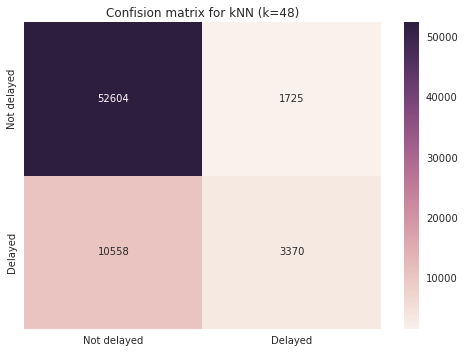

In [25]:
ax = plot_confusion()

In [26]:
assert_equal(isinstance(ax, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

texts = [t.get_text() for t in ax.texts]
assert_equal(texts, ['10558', '3370', '52604', '1725'])
             
x_tick_labels = [l.get_text() for l in ax.get_xticklabels()]
y_tick_labels = [l.get_text() for l in ax.get_yticklabels()]
assert_equal(y_tick_labels, ['Delayed', 'Not delayed'])

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")